# `nb09`: MCMC

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm

# Metropolis-Hastings

In [2]:
def mh_sample(theta0, n, log_target, q, seed=0):
    np.random.seed(seed)
    
    theta_t = theta0
    thetas = []
    accepts = 0
    
    for i in tqdm.tqdm(range(n)):
        theta_prop = q(theta_t)
        u = np.random.rand()
        
        if np.log(u) < log_target(theta_prop) - log_target(theta_t):
            theta_t = theta_prop
            accepts += 1
        
        thetas.append(theta_t)
        
    return np.array(thetas), accepts / n

In [3]:
thetas, accept_ratio = mh_sample(0.0, 10000, 
                                 lambda theta: -np.abs(theta),
                                 lambda theta_t: theta_t + np.random.randn())

print("Accept ratio =", accept_ratio)

100%|█████████████| 10000/10000 [00:00<00:00, 322944.32it/s]

Accept ratio = 0.7106


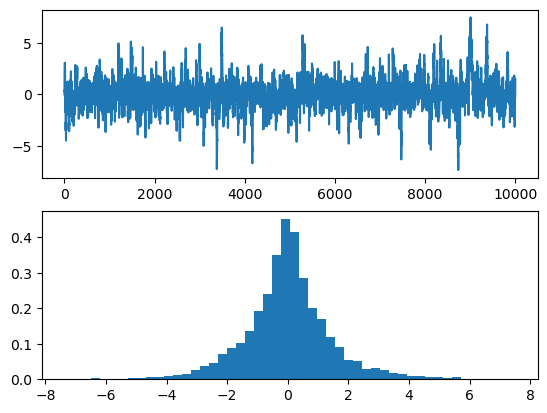

In [4]:
fig, ax = plt.subplots(2)

ax[0].plot(thetas)
ax[1].hist(thetas, bins=50, density=True)

plt.show()

## Proposals

100%|█████████████| 10000/10000 [00:00<00:00, 261434.86it/s]


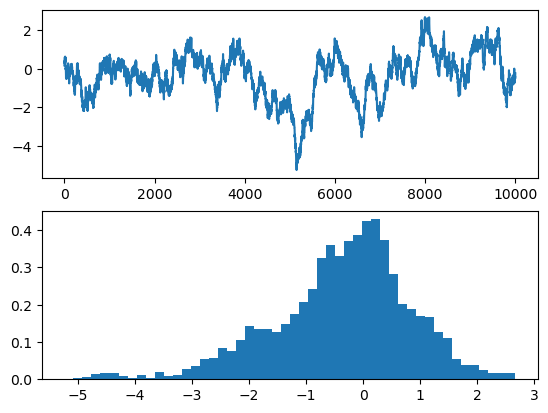

Accept ratio = 0.9633


In [5]:
# Narrow proposal
thetas, accept_ratio = mh_sample(0.0, 10000, 
                                 lambda theta: -np.abs(theta),
                                 lambda theta_t: theta_t + 0.1 * np.random.randn())

fig, ax = plt.subplots(2)

ax[0].plot(thetas)
ax[1].hist(thetas, bins=50, density=True)

plt.show()

print("Accept ratio =", accept_ratio)

100%|█████████████| 10000/10000 [00:00<00:00, 261813.46it/s]


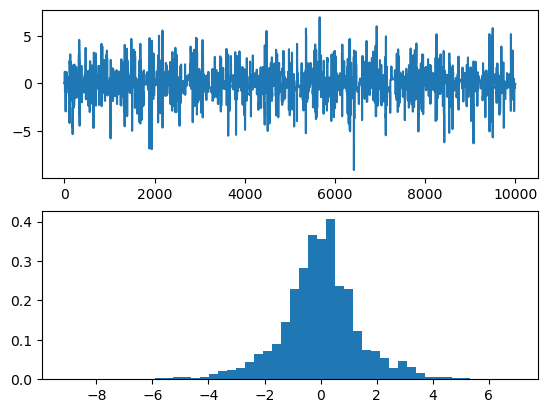

Accept ratio = 0.165


In [6]:
# Wide proposal
thetas, accept_ratio = mh_sample(0.0, 10000, 
                                 lambda theta: -np.abs(theta),
                                 lambda theta_t: theta_t + 10.0 * np.random.randn())

fig, ax = plt.subplots(2)

ax[0].plot(thetas)
ax[1].hist(thetas, bins=50, density=True)

plt.show()

print("Accept ratio =", accept_ratio)

<div class="alert alert-success">
    
**Exercise**. Repeat the execution above but for 1000 samples. What do you observe? 
    
</div>

<div class="alert alert-success">
    
**Exercise**. Try with non-Gaussian proposal distribution.
    
</div>

In summary:
- Too narrow proposals lead to very high acceptance rates but persistent random walks that can seriously bias the sample. 
- Too wide proposals lead to very low acceptance rates and long sequences of identical states that can be seen as spikes in the histogram of the samples.

## Thining, Warm up

100%|█████████████| 10000/10000 [00:00<00:00, 253519.58it/s]


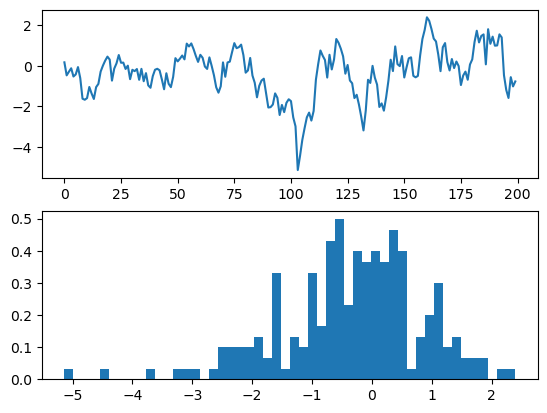

Accept ratio = 0.9633


In [7]:
# Thinning
thetas, accept_ratio = mh_sample(0.0, 10000, #*50,
                                 lambda theta: -np.abs(theta),
                                 lambda theta_t: theta_t + 0.1 * np.random.randn())

fig, ax = plt.subplots(2)

ax[0].plot(thetas[::50])  # keep 1/50 of the samples
ax[1].hist(thetas[::50], bins=50, density=True)

plt.show()

print("Accept ratio =", accept_ratio)

100%|█████████████| 10000/10000 [00:00<00:00, 234689.70it/s]


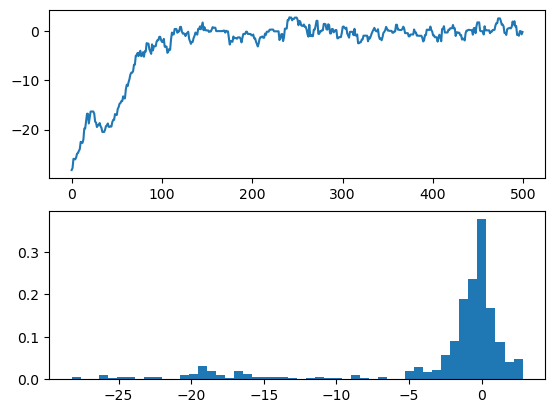

Accept ratio = 0.7082


In [8]:
# Warm up
thetas, accept_ratio = mh_sample(-30.0, 10000,
                                 lambda theta: -np.abs(theta),
                                 lambda theta_t: theta_t + np.random.randn())

fig, ax = plt.subplots(2)

ax[0].plot(thetas[:500])  
ax[1].hist(thetas[:500], bins=50, density=True)

plt.show()

print("Accept ratio =", accept_ratio)

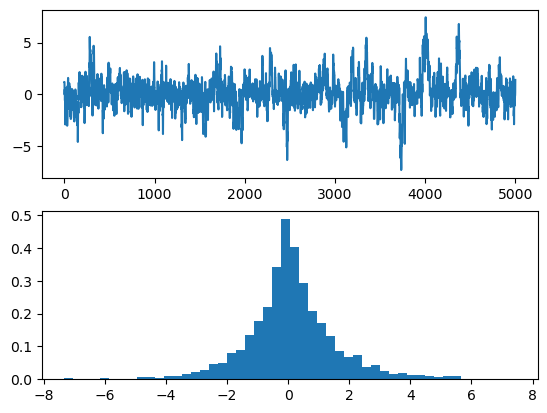

In [9]:
fig, ax = plt.subplots(2)

ax[0].plot(thetas[len(thetas)//2:])   # discard the first half
ax[1].hist(thetas[len(thetas)//2:], bins=50, density=True)

plt.show()

<div class="alert alert-success">
    
**Exercise**. Run Metropolis-Hastings to sample from a mixture of two Gaussians.
    
</div>

<div class="alert alert-success">
    
**Exercise**. Run Metropolis-Hastings to sample from a density $\pi(\theta) = \frac{1}{Z} \theta^2$ supported on $[-1, 1]$.
</div>

# Bayesian inference with MCMC

In [10]:
# Generative model
theta_true = np.array([-3.0, 0.0, np.log(5.0)])

def generate(n_samples, theta_true):
    x = np.random.rand(n_samples) * 20 - 10
    x = np.sort(x)
    
    y = theta_true[0] * x + theta_true[1] + np.random.randn(n_samples) * np.exp(theta_true[2])
    
    return x, y

In [11]:
x, y = generate(50, theta_true)

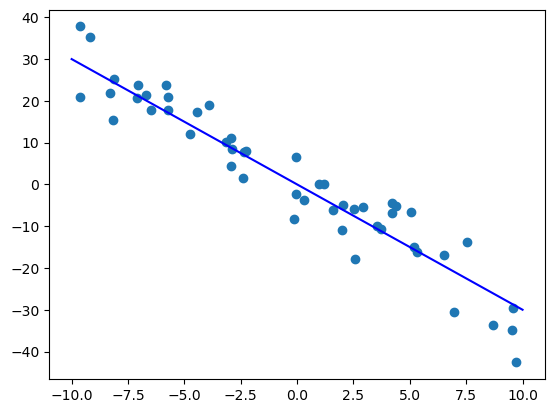

In [12]:
fig = plt.figure()
ax = plt.axes()
ax.scatter(x, y)
xs = np.linspace(-10, 10)
ax.plot(xs, theta_true[0] * xs + theta_true[1], color="blue")
plt.show()

In [13]:
# Sampling the posterior
from scipy.stats import norm, multivariate_normal

def log_likelihood(theta, x, y):
    return norm.logpdf(y, loc=theta[0] * x + theta[1], scale=np.exp(theta[2])).sum()

def log_prior(theta):   
    return (norm.logpdf(theta[0], loc=0., scale=3) + 
            norm.logpdf(theta[1], loc=0., scale=3) +
            norm.logpdf(theta[2], loc=np.log(1.0), scale=3))

def log_posterior(theta, x, y):
    return log_likelihood(theta, x, y) + log_prior(theta) # -normalizing constant (not needed!)

In [14]:
thetas, accept_ratio = mh_sample(np.array([0.0, 0.0, 0.0]), 10000,
                                 lambda theta: log_posterior(theta, x, y),
                                 lambda theta_t: theta_t + multivariate_normal.rvs(mean=[0.0, 0.0, 0.0], cov=0.1))

print("Accept ratio =", accept_ratio)

100%|███████████████| 10000/10000 [00:08<00:00, 1113.50it/s]

Accept ratio = 0.1987


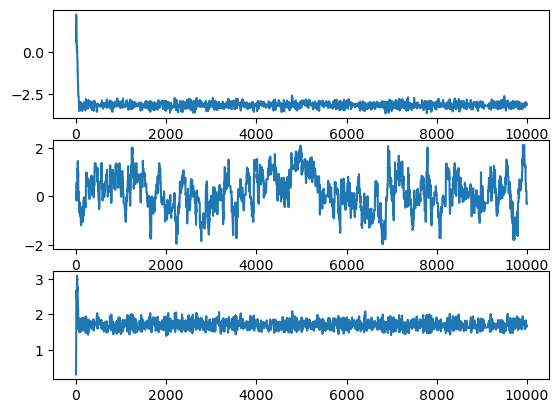

In [15]:
fig, ax = plt.subplots(3)

for i in range(3):
    ax[i].plot(thetas[:, i])

plt.show()

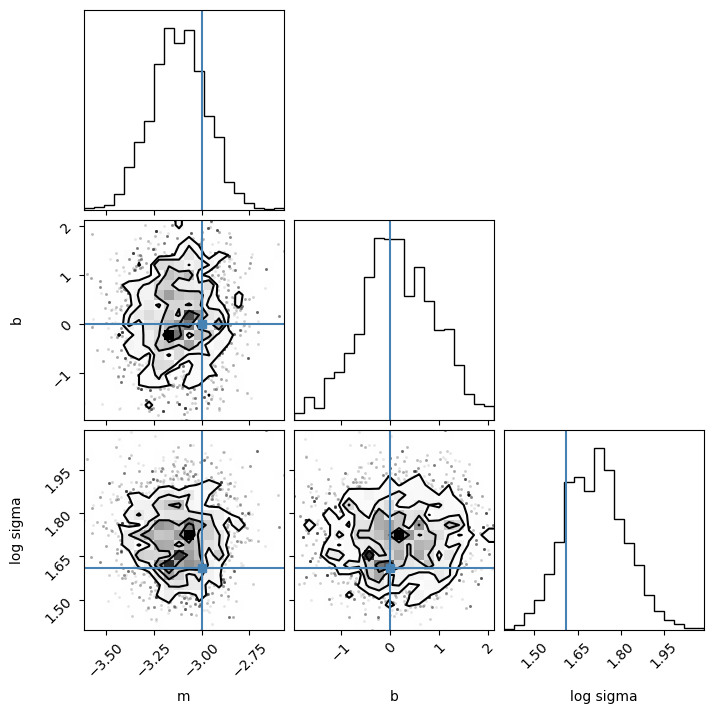

In [16]:
import corner
fig = corner.corner(thetas[1000:], labels=["m", "b", "log sigma"], truths=theta_true)

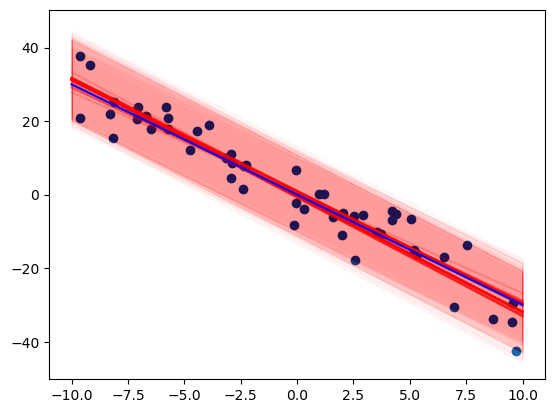

In [17]:
fig = plt.figure()
ax = plt.axes()
ax.scatter(x, y)
xs = np.linspace(-10, 10)
warmup = 1000

for i in range(100):
    ax.plot(xs, thetas[warmup+i, 0] * xs + thetas[warmup+i, 1], color="red", alpha=0.1)
    ax.fill_between(xs, 
                    thetas[warmup+i, 0] * xs + thetas[warmup+i, 1] - 2*np.exp(thetas[warmup+i, 2]), 
                    thetas[warmup+i, 0] * xs + thetas[warmup+i, 1] + 2*np.exp(thetas[warmup+i, 2]), 
                    color="red", alpha=0.002)

ax.plot(xs, theta_true[0] * xs + theta_true[1], color="blue")
plt.show()

<div class="alert alert-success">
    
**Exercise**. Repeat with fewer observations. What do you observe?
    
</div>

# `emcee`

In [18]:
import emcee

pos = np.array([0.0, 0.0, 0.0]) + 0.1 * np.random.randn(10, 3)
nwalkers, ndim = pos.shape

In [19]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(x, y))
sampler.run_mcmc(pos, 10000 // nwalkers, progress=True);

100%|██████████████████| 1000/1000 [00:04<00:00, 239.57it/s]


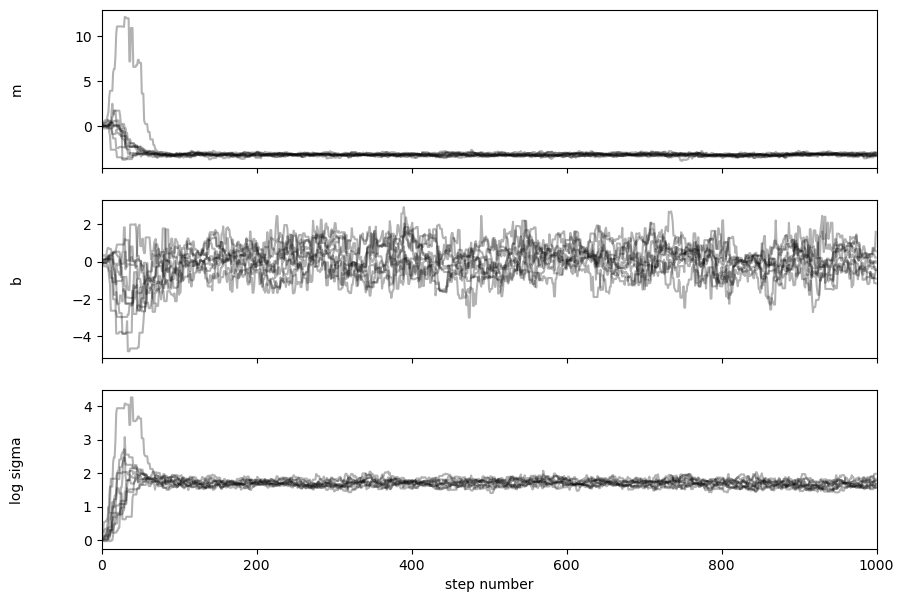

In [20]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log sigma"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")
plt.show()

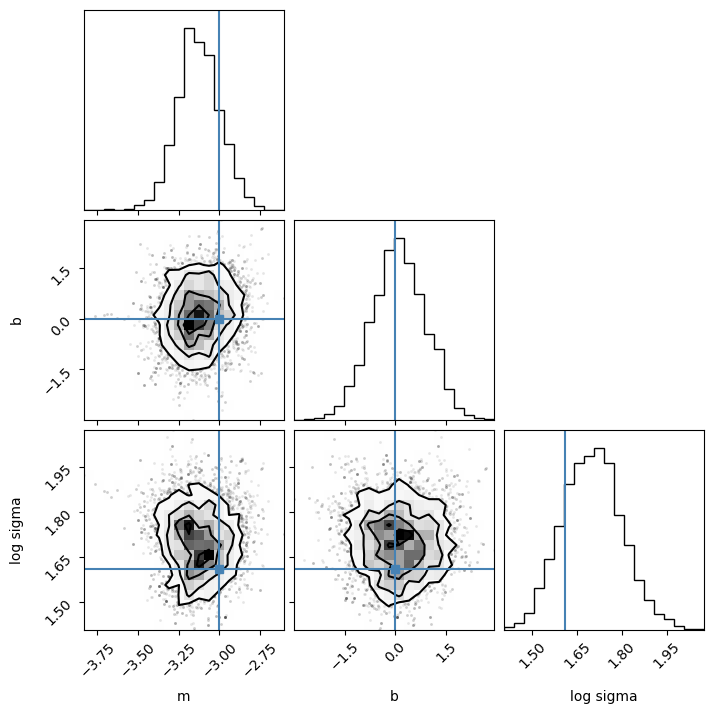

In [21]:
import corner
thetas = sampler.get_chain(flat=True, discard=200)
fig = corner.corner(thetas, labels=labels, truths=theta_true)

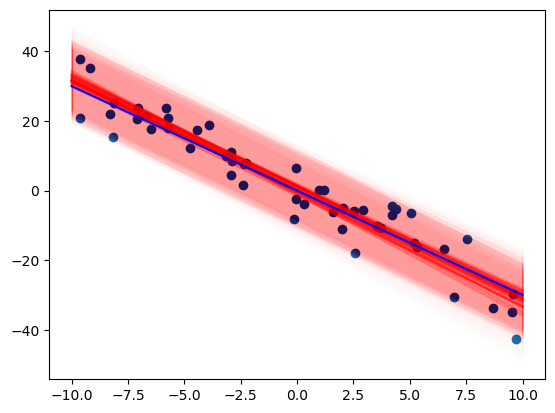

In [22]:
fig = plt.figure()
ax = plt.axes()
ax.scatter(x, y)
xs = np.linspace(-10, 10)
warmup = 1000

for i in range(100):
    ax.plot(xs, thetas[warmup+i, 0] * xs + thetas[warmup+i, 1], color="red", alpha=0.1)
    ax.fill_between(xs, 
                    thetas[warmup+i, 0] * xs + thetas[warmup+i, 1] - 2*np.exp(thetas[warmup+i, 2]), 
                    thetas[warmup+i, 0] * xs + thetas[warmup+i, 1] + 2*np.exp(thetas[warmup+i, 2]), 
                    color="red", alpha=0.002)

ax.plot(xs, theta_true[0] * xs + theta_true[1], color="blue")
plt.show()

In [23]:
tau = sampler.get_autocorr_time()
tau

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [36.14472795 35.53736898 21.77446708]